In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
from keras import losses


Using TensorFlow backend.


In [2]:
filename = '/home/mcoughlin/Seismon/Predictions/H1O1O2_CMT_GPR/earthquakes.txt' 


'''
1: earthquake gps time
2: earthquake mag
3: p gps time
4: s gps time
5: r (2 km/s)
6: r (3.5 km/s)
7: r (5 km/s)
8: predicted ground motion (m/s)
9: lower bounding time
10: upper bounding time
11: latitude
12: longitude
13: distance
14: depth (m)
15: azimuth (deg)
16: nodalPlane1_strike
17: nodalPlane1_rake
18: nodalPlane1_dip
19: momentTensor_Mrt
20: momentTensor_Mtp
21: momentTensor_Mrp
22: momentTensor_Mtt
23: momentTensor_Mrr
24: momentTensor_Mpp
25: peak ground velocity gps time
26: peak ground velocity (m/s)
27: peak ground acceleration gps time
28: peak ground acceleration (m/s^2)
29: peak ground displacement gps time
30: peak ground displacement (m)
31: Lockloss time
32: Detector Status
'''

data = pd.read_csv(filename,delimiter=' ',header=None)
#data.to_csv('H1O1O2_CMT_GPR.csv')

In [3]:
# Take log 
data[[1,12, 13,25]]  = np.log10(data[[1,12, 13,25]])
Rf_Amp_thresh = -8; 
index = data[25] > Rf_Amp_thresh

data = data[:][index]

In [4]:
# Select features
FeatSet_index = [1,10,7,11,12,13,14,15,16,17,18,19,20,21,22,23]
#FeatSet_index = [2,3,24,26,28,30] #  these paramaters makes no sense
#FeatSet_index = [18,19,20,21,22,23] #  these lower set has just the moment tensor parameters
FeatSet_index = [1,7,10,11,12,13,14,15,16,17] #  these lower set paramaters makes  sense
#FeatSet_index = [1,12,13] #  Just Mag, Dist, Depth


Target_index = [25]


# Artificially increase samples
data_temp = data
copy_num = 8
noise_level = 1e-2



Rfamp_orig = data_temp[Target_index];
data_orig =  data_temp   

In [5]:


def boost_samples(data,FeatSet_index, Target_index,copy_num=8,noise_level=1e-3):

    # Artificially increase samples
    data_temp = data
    #copy_num = 1
    #noise_level = 1e-1

    for i in range(copy_num):
        data_temp = data_temp.append(data_temp)

    Rfamp_orig = data_temp[Target_index];
    data_orig =  data_temp   

    x1 = data_temp[FeatSet_index][:]
    x2 = np.random.randn(*data_temp[FeatSet_index][:].shape)*noise_level
    data_temp[FeatSet_index] = x1 + np.multiply(x1,x2)


    y1 = data_temp[Target_index][:]
    y2 = np.random.randn(len(data_temp[Target_index][:]))*noise_level
    y3 = np.expand_dims(y2,axis=1)
    data_temp[Target_index] = y1 + np.multiply(y1,y3)

    data = data_temp
    data_unscaled = data
    return data



def boost_x_samples(x_samples,copy_num=3,noise_level=1e-3):
    # Artificially increase samples
    data_temp = x_samples
    #copy_num = 2
    #noise_level = 1e-2

    for i in range(copy_num):
        data_temp = np.vstack((data_temp,data_temp))


    data_orig =  data_temp   

    x1 = data_temp
    x2 = np.random.randn(*data_temp.shape)*noise_level
    x_samples_boosted = x1 + np.multiply(x1,x2)
    return x_samples_boosted, data_orig



def boost_y_samples(y_samples,copy_num=3,noise_level=1e-3):
    # Artificially increase samples
    data_temp = y_samples
    #copy_num = 2
    #noise_level = 1e-2

    for i in range(copy_num):
        data_temp = np.vstack((data_temp,data_temp))


    data_orig =  data_temp   

    y1 = data_temp
    y2 = np.random.randn(len(data_temp))*noise_level
    y3 = np.expand_dims(y2,axis=1)
    y_samples_boosted = y1 + np.multiply(y1,y3)
    return y_samples_boosted, data_orig

In [6]:
y_test.shape

NameError: name 'y_test' is not defined

In [7]:
data = data_temp

data_unscaled = data
X_us = np.asarray(data[FeatSet_index])
Y_us = np.asarray(data[Target_index])
x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(X_us, Y_us, test_size=0.4,random_state=42)
x_train_us, x_val_us, y_train_us, y_val_us = train_test_split(x_train_us, y_train_us, test_size=0.4,random_state=42)

# Normalize Data
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

X = np.asarray(data[FeatSet_index])
Y = np.asarray(data[Target_index])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3,random_state=42)



In [8]:
# boost Samples
x_train = boost_x_samples(x_train); x_train = x_train[0];
x_val   = boost_x_samples(x_val);   x_val   = x_val[0];
x_test  = boost_x_samples(x_test);  x_test  = x_test[0];

y_train = boost_y_samples(y_train); y_train = y_train[0];
y_val   = boost_y_samples(y_val);   y_val   = y_val[0];
y_test  = boost_y_samples(y_test);  y_test  = y_test[0];



In [9]:
#############################################
# Construct the neural network and train it #
#############################################

inp_layer = x_train.shape[1]
dense_layers = 6
dense_activation = 'elu'
optimizer = 'adam'
loss = 'mse'
batch_size = 2000 #100000
Nepoch = 50
verbose = 1
Nbatch = 1000#1000

# define the network topology  -- -- -- - - -  -  -   -   -    -  
model = Sequential()
model.add(Dense(inp_layer, input_shape=(inp_layer,), activation = 'linear'))

# this layer increases trainging time but seems to not increase performance
model.add(Dense(inp_layer, activation = 'elu'))
#model.add(Dense(Nang+Nspot, activation = 'elu'))  # try one more fully connected 

g = range( dense_layers ) # add layers; decrease size of each by half 
g.reverse()  

#for k in g[0:-2]:
#    model.add(Dense(2**k, activation = dense_activation))  

#model.add(Dense(8192,activation='relu')) 
#model.add(Activation("linear"))
model.add(Dense(4096,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(2048,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(1024,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(512,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(256,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(128,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(64,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(32,activation='relu')) 
model.add(Activation("linear"))
model.add(Dense(16,activation='relu'))     
model.add(Activation("linear"))
model.add(Dense(8,activation='relu')) 

model.add(Dense(1,    activation = 'linear'))
model.compile(optimizer=optimizer, loss=loss)                                 
#model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss=loss) 

In [10]:
model.fit(x_train, y_train,
                   validation_data = (x_val,y_val),
                   batch_size      = Nbatch,
                   epochs          = Nepoch,
                   verbose         = verbose)   

Train on 3672 samples, validate on 1584 samples
Epoch 1/50
3672/3672 [==============================] - 3s - loss: 0.0741 - val_loss: 0.0270
Epoch 2/50
3672/3672 [==============================] - 2s - loss: 0.0326 - val_loss: 0.0248
Epoch 3/50
3672/3672 [==============================] - 2s - loss: 0.0253 - val_loss: 0.0167
Epoch 4/50
3672/3672 [==============================] - 2s - loss: 0.0223 - val_loss: 0.0159
Epoch 5/50
3672/3672 [==============================] - 3s - loss: 0.0200 - val_loss: 0.0145
Epoch 6/50
3672/3672 [==============================] - 2s - loss: 0.0178 - val_loss: 0.0123
Epoch 7/50
3672/3672 [==============================] - 2s - loss: 0.0157 - val_loss: 0.0118
Epoch 8/50
3672/3672 [==============================] - 2s - loss: 0.0139 - val_loss: 0.0092
Epoch 9/50
3672/3672 [==============================] - 2s - loss: 0.0123 - val_loss: 0.0080
Epoch 10/50
3672/3672 [==============================] - 2s - loss: 0.0112 - val_loss: 0.0074
Epoch 11/50
3672/3672

In [11]:
y_pred = model.predict(x_test)

Percentage captured within a factor of 3 = 89.41


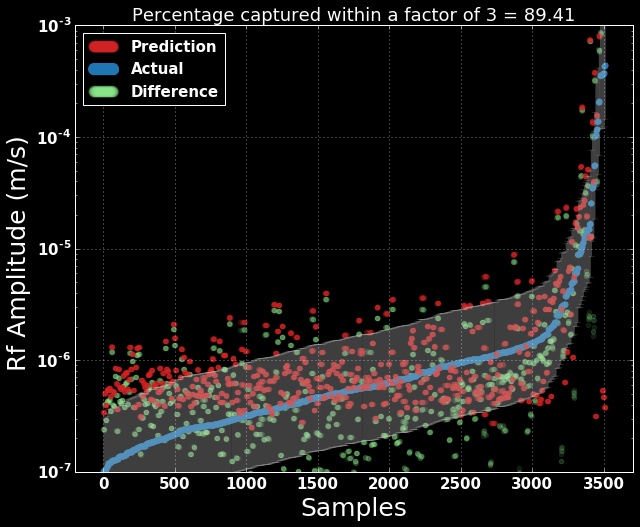

In [14]:
# Rescale back to original 
#y_test = y_test*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])
#y_pred = y_pred*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])

## Percentage within the specified factor
Fac = 3
IDX = y_pred/y_test >= 1
K = y_pred[IDX]
Q = y_test[IDX]
L = y_pred[~IDX]
M = y_test[~IDX]
Upper_indices = [i for i, x in enumerate(K <= Fac*Q) if x == True]
Lower_indices = [i for i, x in enumerate(L >= M/Fac) if x == True]
Percent_within_Fac = (len(Upper_indices) + len(Lower_indices))/len(y_pred)*100
print("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))

rescale_id = 1

if rescale_id==0 :
    # sort results in Ascending order
    y_test_sort = np.sort(y_test,axis=0)
    y_pred_sort = y_pred[np.argsort(y_test,axis=0)]
elif rescale_id == 1:
    data_origScale= min_max_scaler.inverse_transform(data)
    data_origScale = pd.DataFrame(data_origScale)

    # Rescale back to original 
    y_test_rescaled = y_test*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])
    y_pred_rescaled = y_pred*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])
    # sort results in Ascending order
    y_test_sort = np.sort(y_test_rescaled,axis=0)
    y_pred_sort = y_pred_rescaled[np.argsort(y_test_rescaled,axis=0)]

    y_test_sort = 10**(y_test_sort)
    y_pred_sort = 10**(y_pred_sort)





Diff = abs(y_pred_sort - np.expand_dims(y_test_sort,axis=1))

# Errorbar values
yerr_lower = y_test_sort - y_test_sort/Fac
yerr_upper = Fac*y_test_sort - y_test_sort


idx = np.arange(0,len(y_test_sort))


font = {'weight' : 'bold',
        'size'   : 15}


plt.rc('font', **font)
plt.rc('legend',**{'fontsize':15})


plt.figure(figsize=(10,8))

plt.style.use('dark_background')
#plt.style.use('ggplot')

diff_plt = plt.scatter(idx,Diff,color='lightgreen',alpha=0.1)


errorbar_plt = plt.errorbar(idx,y_test_sort,yerr=[yerr_lower,yerr_upper], alpha=0.05 ,color='lightgrey')
actual_plt = plt.scatter(idx,y_test_sort,color='#1f77b4',alpha=0.9)


idx2 = np.arange(0,len(y_pred_sort))
pred_plt = plt.scatter(idx2,y_pred_sort,color='#d62728',alpha=0.2)      



plt.yscale('log')
plt.grid()
plt.ylim([1e-7, 1e-3])
#plt.ylim([0, 1])
#plt.ylabel('Rf Amplitude (m/s) \n (Normalized to 1)',fontsize=25)
plt.ylabel('Rf Amplitude (m/s) ',fontsize=25)
plt.xlabel('Samples',fontsize=25)
plt.title("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))
legend_plt = plt.legend([pred_plt,actual_plt, diff_plt],['Prediction', 'Actual', 'Difference'],loc=2,markerscale=2., scatterpoints=100)


plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(linestyle=':')

#plt.savefig('DNN_Rfamp_everything_except_moment_tensor_params_3.png',bbox_inches='tight')
#plt.savefig('DNN_Rfamp_everything_Mag_dist_depth_.png',bbox_inches='tight')
#plt.savefig('DNN_Rfamp_correct_noise_1e-2_run_iter_3000_9_layers_adaptOptimizer.png',bbox_inches='tight')

In [ ]:

# Save Model
save_results = 1
run_number = 3


if save_results:
    
    # Create directory
    result_folder_name = './Saved_Models/Model_{}'.format(run_number)
    os.makedirs(result_folder_name)
    # Save Figure 
    plt.savefig('./Saved_Models/Model_{}/DNN_Rfamp_results.png'.format(run_number),bbox_inches='tight')
    
    # Save Model
    # serialize model to JSON
    model_json = model.to_json()
    with open("./Saved_Models/Model_{}/model.json".format(run_number), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("./Saved_Models/Model_{}/model.h5".format(run_number))
    print("Saved model to disk")
 

In [ ]:
# Load Saved Model

run_number = 2
result_folder_name = './Saved_Models/Model_{}'.format(run_number)
 
    
# load json and create model
json_file = open('./Saved_Models/Model_{}/model.json'.format(run_number), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('./Saved_Models/Model_{}/model.h5'.format(run_number)  )
print("Loaded model from disk")


In [ ]:

# ScratchWork : Ignore


data_origScale= min_max_scaler.inverse_transform(data)
data_origScale = pd.DataFrame(data_origScale)

# Rescale back to original 
y_test_rescaled = y_test*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])
y_pred_rescaled = y_pred*(max(data_origScale[25]) - min(data_origScale[25])) + min(data_origScale[25])

## Percentage within the specified factor
Fac = 2
IDX = y_pred_rescaled/y_test_rescaled >= 1
K = y_pred[IDX]
Q = y_test[IDX]
L = y_pred[~IDX]
M = y_test[~IDX]
Upper_indices = [i for i, x in enumerate(K <= Fac*Q) if x == True]
Lower_indices = [i for i, x in enumerate(L >= M/Fac) if x == True]
Percent_within_Fac = (len(Upper_indices) + len(Lower_indices))/len(y_pred)*100
print("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))

# sort results in Ascending order
y_test_sort = np.sort(y_test_us,axis=0)
y_pred_sort = y_pred_rescaled[np.argsort(y_test_us,axis=0)]


y_test_sort = 10**(y_test_sort)
y_pred_sort = 10**(y_pred_sort)

# Errorbar values
yerr_lower = y_test_sort - y_test_sort/Fac
yerr_upper = Fac*y_test_sort - y_test_sort


idx = np.arange(0,len(y_test_sort))


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}


plt.rc('font', **font)
plt.rc('legend',**{'fontsize':15})


plt.figure(figsize=(10,8))
actual_plt = plt.scatter(idx,y_test_sort,color='red',alpha=0.7,s=5)
errorbar_plt = plt.errorbar(idx,y_test_sort,yerr=[yerr_lower,yerr_upper], alpha=0.005 )

idx2 = np.arange(0,len(y_pred_sort))
pred_plt = plt.scatter(idx2,y_pred_sort,color='green',alpha=0.7)      

plt.yscale('log')
plt.grid()
plt.ylim([1e-7, 1e-3])
plt.ylabel('Rf Amplitude',fontsize=25)
plt.xlabel('Samples',fontsize=25)
plt.title("Percentage captured within a factor of {} = {:.2f}".format(Fac,Percent_within_Fac))
plt.legend([pred_plt,actual_plt],['Prediction', 'Actual'],loc=2)
plt.autoscale(enable=True, axis='x', tight=True)

#plt.savefig('DNN_Rfamp.png',bbox_inches='tight')

